<a href="https://colab.research.google.com/github/odesay97/MachineLearing_Class/blob/main/9_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM & GRU

기본 순환층은 긴 시퀀스를 학습하기 어려움

시퀀스가 길수록 순환되는 은닉 상태에 담긴 정보가 점차 희석되기 떄문

따라서 멀리 떨어져 있는 단어 정보를 인식하는데 어려울 수 있음

이를 극복하기 위해 좀 더 복잡한 LSTM과 GRU 셀이 발명됨

**LSTM(Long Short-Term Memory)**

단기 기억을 오래 기억하기 위해 고안됨

입력과 이전 타임스템의 은닉상태를 가중치에 곱한 후 활성화 함수를 통과시켜 다음 은닉 상태를 만듬

이때 시그모이드 활성화 함수를 사용

또한 tanh 활성화 함수를 통과한 어떤 값과 곱해져서 은닉 상태를 만듬

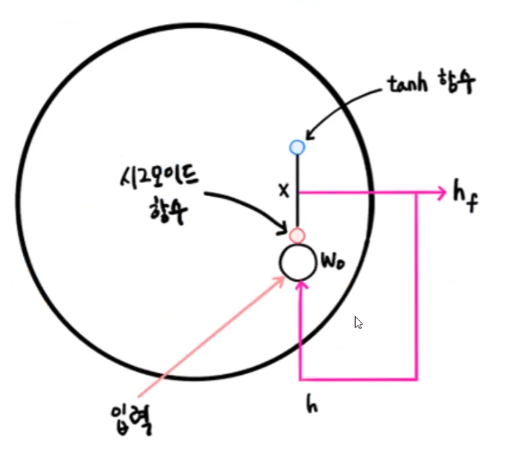

w_o는 w_x(입력에 대한 가중치)와 w_h(은닉 상태에 대한 가중치)를 합쳐서 표현한 가중치

x는 곱셈

-----------

추가로 셀 상태(cell state)라 부르는 값이 존재함

셀 상태는 은닉 상태와는 다르게 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 되는 값

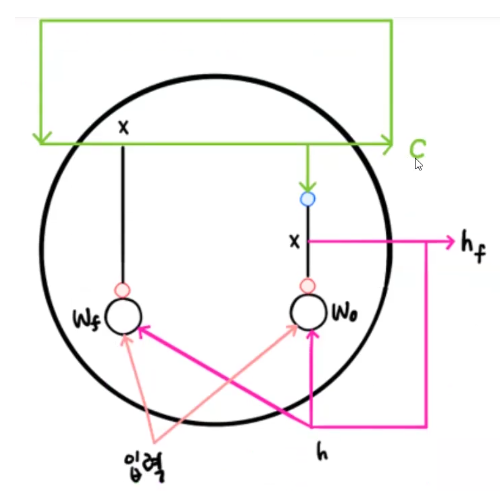

셀 상태는 c로 표시하며 다음과 같이 계산됨

먼저 입력과 은닉 상태를 또다른 가중치 w_f에 곱한 다음 시그모이드 함수를 통과시킴

이전 타임 스텝의 셀 상태와 곱하여 새로운 셀 상태를 만듬

이 셀 상태는 오른쪽의 tanh함수를 통과하여 새로운 은닉 상태를 만드는데 기여함

여기서 w_f와 w_o는 서로 다른 값이며 이 값들을 사용하는 작은 두 셀은 각기 다른 기능을 위해 훈련됨

-----------

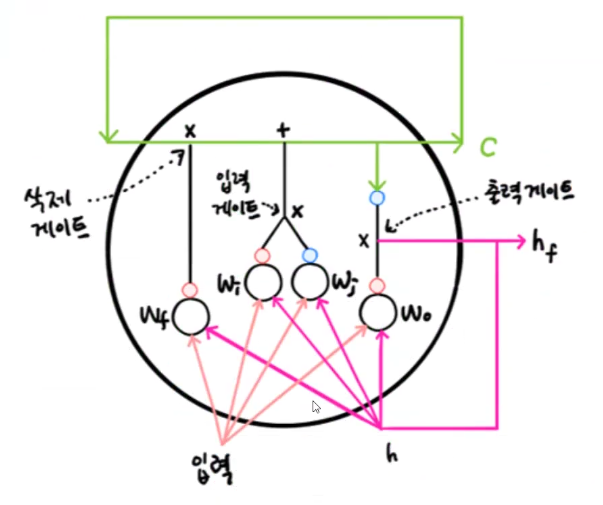


In [1]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [2]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

17464789/17464789 [==============================] - 1s 0us/step


In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [4]:
# LSTM 신경망 훈련
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8809 (34.41 KB)
Trainable params: 8809 (34.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Embedding 클래스는 500개의 각 토큰의 크기가 16인 벡터로 변경했기 때문에 총 500*16 = 8000개의 모델 파라미터를 가짐

LSTM 층은 4개의 셀로 구성됨

하나의 셀의 임베딩 벡터의 크기가 16이므로 8개의 뉴런과 곱하기 위해 필요한 가중치 16 * 8 = 128개를 가짐 또한 은닉 상태에서 곱해지는 가중치 8 * 8 = 64개가 있으며, 추가로 8개의 절편이 있으므로 이 셀에 있는 전체 모델 파라미터의 개수는 128+64+8 = 200개

LSTM층의 전체 모델 파라미터의 개수는 200 * 4 = 800개

Dense 층의 가중치는 입력으로 들어오는 LSTM 층의 출력 8개에 해당하는 가중치 8개에 하나의 절편이 추가되어 총 9개

In [5]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 27s 74ms/step - loss: 0.6927 - accuracy: 0.5277 - val_loss: 0.6924 - val_accuracy: 0.5368
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 32s 102ms/step - loss: 0.6916 - accuracy: 0.5677 - val_loss: 0.6911 - val_accuracy: 0.5668
Epoch 3/100
313/313 [==============================] - 20s 65ms/step - loss: 0.6896 - accuracy: 0.6011 - val_loss: 0.6883 - val_accuracy: 0.6062
Epoch 4/100
313/313 [==============================] - 16s 52ms/step - loss: 0.6842 - accuracy: 0.6363 - val_loss: 0.6792 - val_accuracy: 0.6618
Epoch 5/100
313/313 [==============================] - 27s 87ms/step - loss: 0.6589 - accuracy: 0.6827 - val_loss: 0.6277 - val_accuracy: 0.7076
Epoch 6/100
313/313 [==============================] - 23s 75ms/step - loss: 0.6084 - accuracy: 0.7135 - val_loss: 0.5964 - val_accuracy: 0.7114
Epoch 7/100
313/313 [==============================] - 17s 55ms/step - loss: 0.5834 - accuracy: 0.7280 - val_loss: 0.5746 - val_accuracy: 0.7330
Epoch 8/100
313/313 [==============================] - 21s 66ms/step - loss: 0.5617 - accuracy: 0.7452 - val_loss: 0.5553 - val_accuracy: 0.7

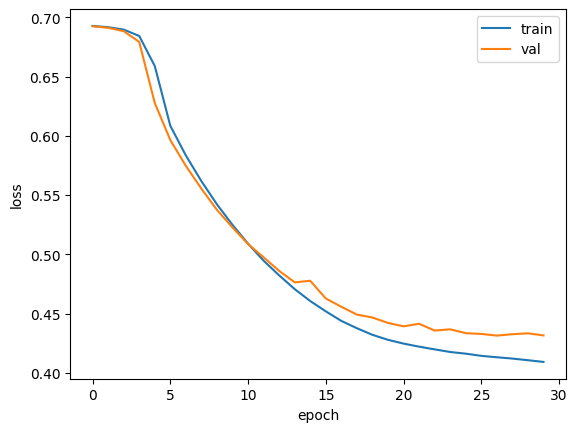

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 순환층에 드롭아웃 적용

완전 연결 신경망과 합성곱 신경망에서는 Dropout클래스를 사용해 드롭아웃을 적용하여 과대적합을 막음

순환층은 자체적으로 드롭아웃 기능을 제공함

SimpleRNN과 LSTM 클래스 모두 dropout 매개변수와 recurrent_dropout 매개변수를 가지고 있음

dropout 매개변수는 셀의 입력에 드롭아웃을 적용

recurrent_dropout매개변수는 순환되는 은닉 상태에 드롭아웃을 적용하나 기술적인 문제로 GPU를 사용하지 못함( 그래서 잘 사용안함 )

In [7]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8809 (34.41 KB)
Trainable params: 8809 (34.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 21s 56ms/step - loss: 0.6924 - accuracy: 0.5317 - val_loss: 0.6917 - val_accuracy: 0.5696
Epoch 2/100
  3/313 [..............................] - ETA: 13s - loss: 0.6919 - accuracy: 0.5365

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 17s 55ms/step - loss: 0.6907 - accuracy: 0.5788 - val_loss: 0.6897 - val_accuracy: 0.5984
Epoch 3/100
313/313 [==============================] - 17s 54ms/step - loss: 0.6879 - accuracy: 0.6057 - val_loss: 0.6861 - val_accuracy: 0.6232
Epoch 4/100
313/313 [==============================] - 17s 54ms/step - loss: 0.6826 - accuracy: 0.6251 - val_loss: 0.6787 - val_accuracy: 0.6392
Epoch 5/100
313/313 [==============================] - 17s 55ms/step - loss: 0.6674 - accuracy: 0.6511 - val_loss: 0.6529 - val_accuracy: 0.6630
Epoch 6/100
313/313 [==============================] - 18s 56ms/step - loss: 0.6258 - accuracy: 0.6999 - val_loss: 0.6108 - val_accuracy: 0.7108
Epoch 7/100
313/313 [==============================] - 17s 55ms/step - loss: 0.5967 - accuracy: 0.7250 - val_loss: 0.5894 - val_accuracy: 0.7274
Epoch 8/100
313/313 [==============================] - 19s 61ms/step - loss: 0.5771 - accuracy: 0.7402 - val_loss: 0.5723 - val_accuracy: 0.73

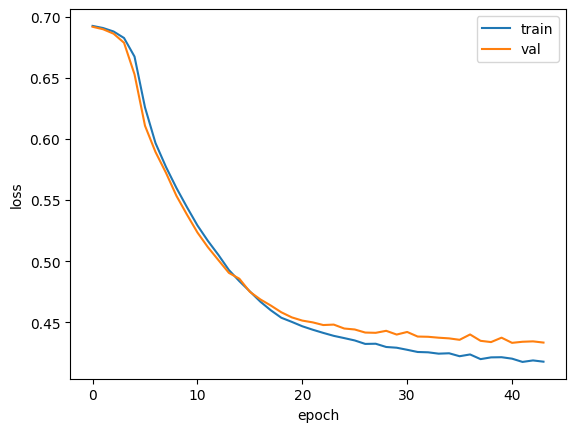

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 2개의 층 연결



순환층을 연결할 떄는 한 가지 주의할 점이 있음

순환층의 은닉 상태는 샘플의 마지막 타임스텝에 대한 은닉 상태만 다음층으로 전달

하지만 순환층을 쌓게 되면 모든 순환 층에 순차 데이터가 필요함

따라서 앞쪽의 순환층이 모든 타임 스텝에 대한 은닉 상태를 출력해야함

오직 마지막 순환층만 마지막 타임스텝의 은닉 상태를 축력해야함

케라스 순환층에서 모든 타임스텝의 은닉 상태를 출력하기 위해 마지막을 제외한 모든 순환층에 return_sequences 매개변수를 True로 지정

In [10]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9353 (36.54 KB)
Trainable params: 9353 (36.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


첫번쨰 LSTM 층이 모든 타임스텝의 은닉상태를 출력하기 때문에 출력 크기가 (None,100,8)로 표시됨

Embedding 클래스는 500개의 각 토큰의 크기가 16인 벡터로 변경했기 때문에 총 500 * 16 = 8000개의 모델 파라미터를 가짐

LSTM층은 4개의 셀로 구성됨

하나의 셀의 입력의 크기가 8이므로 8개의 뉴런과 곱하기 위해 필요한 가중치 8 * 8 = 64를 가짐 또한 은닉 상태에서 곱해지는 가중치 8 * 8 = 64가 있으며 추가로 8개의 절편이 있으므로 이 셀에 있는 전체 모델 파라미터의 개수는 64+64+8 = 136개

LSTM층의 전체 모델 파라미터의 개수는 136 * 4 = 544개

Dense층의 가중치는 입력으로 들어오는 LSTM 층의 출력 8개에 해당하는 가중치 8개에 하나의 절편이 추가되어 총 9개

In [11]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 39s 109ms/step - loss: 0.6929 - accuracy: 0.5168 - val_loss: 0.6927 - val_accuracy: 0.5280
Epoch 2/100
313/313 [==============================] - 31s 100ms/step - loss: 0.6914 - accuracy: 0.5788 - val_loss: 0.6893 - val_accuracy: 0.6228
Epoch 3/100
313/313 [==============================] - 31s 100ms/step - loss: 0.6750 - accuracy: 0.6473 - val_loss: 0.6432 - val_accuracy: 0.6782
Epoch 4/100
313/313 [==============================] - 33s 105ms/step - loss: 0.6067 - accuracy: 0.6889 - val_loss: 0.5798 - val_accuracy: 0.7046
Epoch 5/100
313/313 [==============================] - 32s 104ms/step - loss: 0.5611 - accuracy: 0.7233 - val_loss: 0.5406 - val_accuracy: 0.7358
Epoch 6/100
313/313 [==============================] - 33s 105ms/step - loss: 0.5311 - accuracy: 0.7439 - val_loss: 0.5173 - val_accuracy: 0.7542
Epoch 7/100
313/313 [==============================] - 33s 105ms/step - loss: 0.5142 - accuracy: 0.7568 - val_loss: 0.5006 -

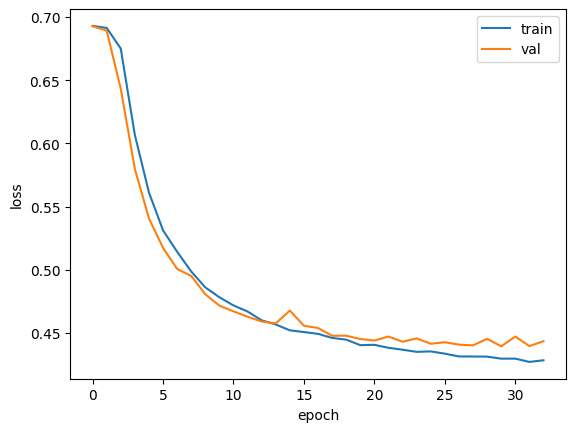

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

**GRU (Gated Recurrent Unit) 구조**

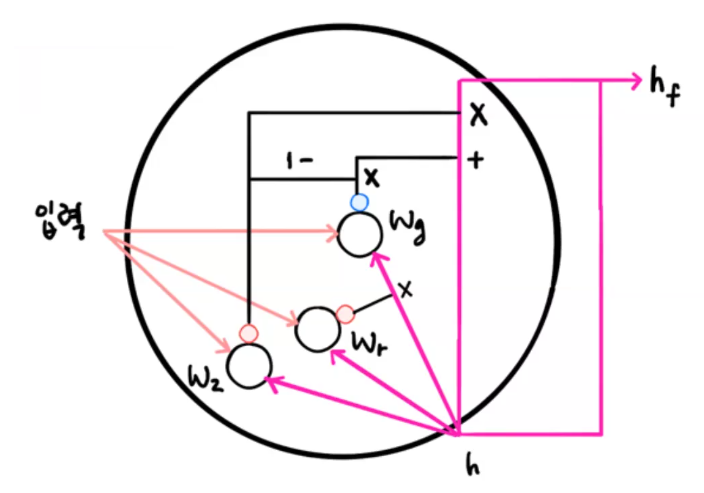

GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀이 3개 들어있음

2개는 시그모이드 활성화 함수를 사용하고 하나는 tanh 활성화 함수를 사용

여기서도 은닉 상태와 입력에 곱해지는 가중치는 간단하게 하나로 표현함

1- 는 출력에서 1을 뺸다는 뜻

w_z를 사용하는 셀의 출력이 은닉 상태에 바로 곱해져 삭제 게이트 역할을 수행

또한 이 출력은 1이 빼진 다음 w_g를 사용하는 셀의 출력에 곱해짐. 이것은 입력되는 정보를 제어하는 역할을 수행

w_r를 사용하는 셀에서 출력된 값은 w_g셀이 사용할 은닉 상태의 정보를 제어

GRU 셀은 LSTM보다 가중치가 적기 떄문에 계산량은 적지만 LSTM 못지 않은 좋은 성능을 내는 것으로 알려져 있음

In [13]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8633 (33.72 KB)
Trainable params: 8633 (33.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


GRU 셀에는 3개의 작은 셀이 있음

작은 셀에는 입력과 은닉 상태에 곱하는 가중치와 절편이 있음

입력에 곱하는 가중치는 16 * 8 = 128개

은닉 상태에 곱하는 가중치는 8 * 8 = 64개

절편은 뉴런마다 하나씩이므로 8개

모두 더하면 128+64+8 = 200

이런 작은 셀들이 3개 있으므로 총 600개의 모델 파라미터가 필요하나 실제로 보면 624개가 있다고 나옴

이 이유는 텐서플로에 구현된 GRU 셀의 계산이 앞의 그림과 조금 다르기 때문임

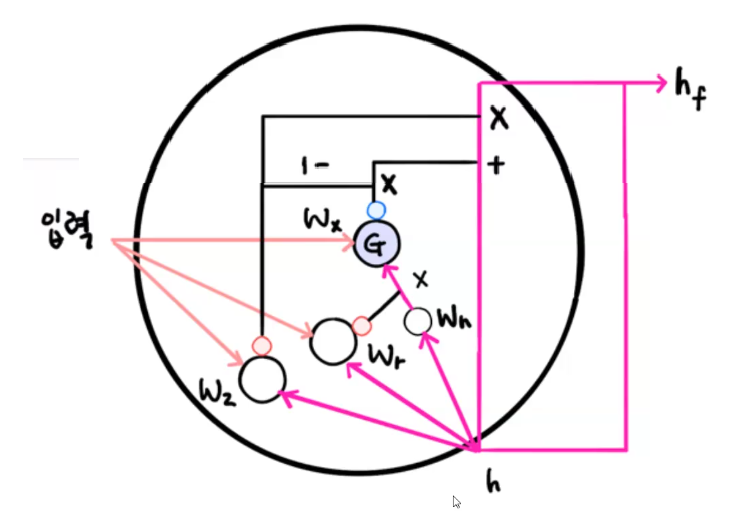

달라지는 부분은 G로 표시된 작은 셀에 들어가는 입력부분

이전 그림의 w_g는 w_x와 w_h로 나누어짐

은닉 상태가 먼저 가중치와 곱해진 다음 가운데 셀의 출력과 곱해짐

이렇게 나누어 계산하면 은닉 상태에 곱해지는 가중치에 절편이 별도로 필요함

**따라서 작은 셀마다 하나씩 절편이 추가되고 8개의 뉴런이 있으므로 총 24개의 모델 파라미터가 더해짐**

따라서 GRU층의 모델 파라미터 개수는 624개

------

텐서플로가 이런 계산 방식을 사용하는 이유는 GPU를 잘 활용하기 위함

그러나 대부분 GRU 셀을 소개할 떄는 작은 셀이 3개인 그림을 이용

**이렇게 이론과 구현에 차이가 있는 경우가 있으니 조심할 것**

In [14]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 25s 71ms/step - loss: 0.6920 - accuracy: 0.5486 - val_loss: 0.6912 - val_accuracy: 0.5724
Epoch 2/100
313/313 [==============================] - 19s 62ms/step - loss: 0.6898 - accuracy: 0.5790 - val_loss: 0.6889 - val_accuracy: 0.5830
Epoch 3/100
313/313 [==============================] - 19s 59ms/step - loss: 0.6865 - accuracy: 0.5975 - val_loss: 0.6852 - val_accuracy: 0.5958
Epoch 4/100
313/313 [==============================] - 20s 63ms/step - loss: 0.6813 - accuracy: 0.6107 - val_loss: 0.6792 - val_accuracy: 0.5994
Epoch 5/100
313/313 [==============================] - 20s 63ms/step - loss: 0.6732 - accuracy: 0.6204 - val_loss: 0.6701 - val_accuracy: 0.6134
Epoch 6/100
313/313 [==============================] - 19s 60ms/step - loss: 0.6608 - accuracy: 0.6387 - val_loss: 0.6556 - val_accuracy: 0.6302
Epoch 7/100
313/313 [==============================] - 19s 60ms/step - loss: 0.6404 - accuracy: 0.6581 - val_loss: 0.6304 - val_ac

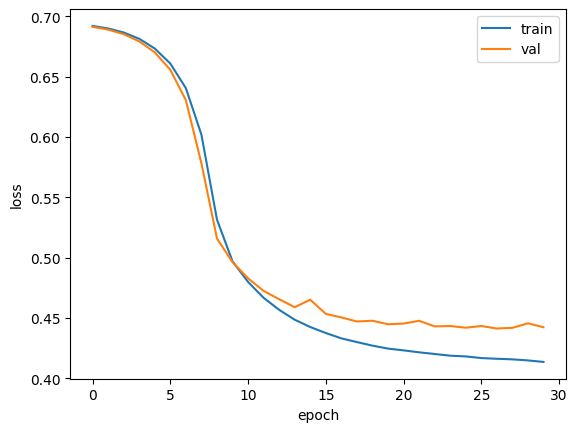

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

모델 평가

In [16]:
test_seq = pad_sequences(test_input, maxlen=100)

rnn_model = keras.models.load_model('best-2rnn-model.h5')

rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 16s 19ms/step - loss: 0.4346 - accuracy: 0.7975


[0.434622585773468, 0.7974799871444702]